Problem statement: 
A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate it if one could predict for them who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction

Solution Objective: 
Build a model predicting churning customers

Machine Learning model adopted:
Supervised Learning Algorithm - Classification(Random forest and naive bayes). I would create a pipeline that combines these two alogrithms for optimized result.

Datasets info: 
This dataset consists of 10,000 customers mentioning their age, salary, marital_status, credit card limit, credit card category, etc. There are nearly 18 features.


In [1]:
import boto3
import sagemaker
from sagemaker import get_execution_role
import sys

role = get_execution_role()
sess = sagemaker.Session()
region = boto3.session.Session().region_name
print("Region = {}".format(region))
sm = boto3.Session().client('sagemaker')

Region = us-east-2


In [2]:
#importing necessary library for this model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import boto3, re, sys, math, json, os, urllib.request
from time import sleep, gmtime, strftime

In [3]:
help(urllib.request.urlretrieve)

Help on function urlretrieve in module urllib.request:

urlretrieve(url, filename=None, reporthook=None, data=None)
    Retrieve a URL into a temporary location on disk.
    
    Requires a URL argument. If a filename is passed, it is used as
    the temporary file location. The reporthook argument should be
    a callable that accepts a block number, a read size, and the
    total file size of the URL target. The data argument should be
    valid URL encoded data.
    
    If a filename is passed and the URL points to a local resource,
    the result is a copy from local file to new file.
    
    Returns a tuple containing the path to the newly created
    data file as well as the resulting HTTPMessage object.



In [4]:
#retrieving the data from our s3 bucket and loading it here in a dataframe
s3 = boto3.resource('s3')
try:
    s3.Object('eugene-sagemaker-bucket', 'BankChurners.csv').download_file('BankChurners.csv')
    print('successful')
except Exception as e:
    print('Data load error: ', e)
    
try:
    data = pd.read_csv('BankChurners.csv', index_col = 0)
    print('dataframe created successfully')
except Exception as e:
    print('Dataframe loading failed: ', e)

successful
dataframe created successfully


In [5]:
#viewing the dataframe
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 768805383 to 714337233
Data columns (total 22 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   Attrition_Flag                                                                                                                      10127 non-null  object 
 1   Customer_Age                                                                                                                        10127 non-null  int64  
 2   Gender                                                                                                                              10127 non-null  object 
 3   Dependent_count                                                      

DATA PREPROCESSING PHASE

In [6]:
#dropping the last two columns
data.drop(data.columns[20:], axis = 1, inplace = True)

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 768805383 to 714337233
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  

In [8]:
#obtaining summary statistics for our given data
data.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [9]:
#checking for the degree of missing values per feature and retrieving result
print(data.isnull().sum())

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64


In [10]:
data.nunique()

Attrition_Flag                 2
Customer_Age                  45
Gender                         2
Dependent_count                6
Education_Level                7
Marital_Status                 4
Income_Category                6
Card_Category                  4
Months_on_book                44
Total_Relationship_Count       6
Months_Inactive_12_mon         7
Contacts_Count_12_mon          7
Credit_Limit                6205
Total_Revolving_Bal         1974
Avg_Open_To_Buy             6813
Total_Amt_Chng_Q4_Q1        1158
Total_Trans_Amt             5033
Total_Trans_Ct               126
Total_Ct_Chng_Q4_Q1          830
Avg_Utilization_Ratio        964
dtype: int64

In [11]:
data.head(10)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,,,,,,,,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
810347208,Existing Customer,51,M,4,Unknown,Married,$120K +,Gold,46,6,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066
818906208,Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,2,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048
710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,5,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113


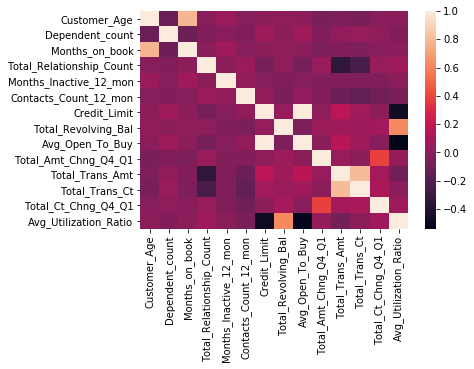

In [12]:
#from above their are no missing values
#next we find the correlation among variables
import seaborn as sns
corr = data.corr()
sns.heatmap(corr)

In [13]:
data.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

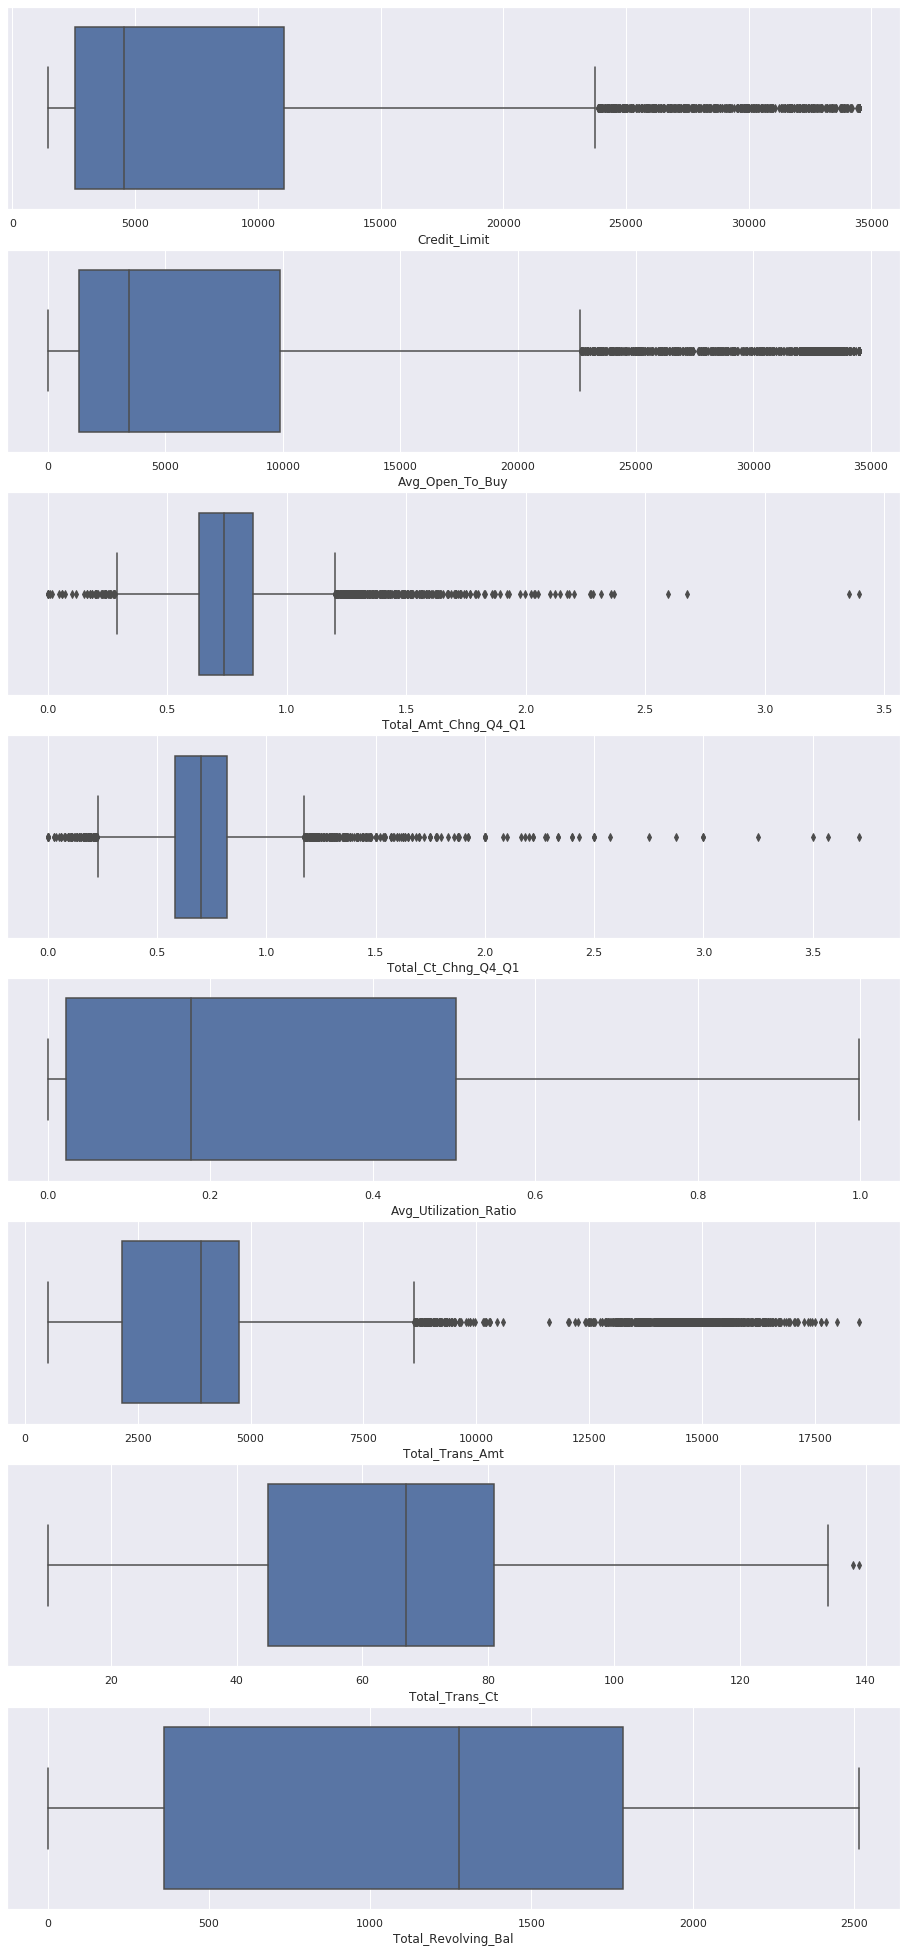

In [14]:
#detecting outliers via the use of boxplot. Since outliers are capable of affecting drastically  our model
sns.set(style= 'whitegrid')
sns.set(rc={'figure.figsize':(16,35)})
f, axes = plt.subplots(8, 1)
sns.boxplot(data['Credit_Limit'], ax = axes[0])
sns.boxplot(data['Avg_Open_To_Buy'], ax = axes[1])
sns.boxplot(data['Total_Amt_Chng_Q4_Q1'], ax = axes[2])
sns.boxplot(data['Total_Ct_Chng_Q4_Q1'], ax = axes[3])
sns.boxplot(data['Avg_Utilization_Ratio'], ax = axes[4])
sns.boxplot(data['Total_Trans_Amt'], ax = axes[5])
sns.boxplot(data['Total_Trans_Ct'], ax = axes[6])
sns.boxplot(data['Total_Revolving_Bal'], ax = axes[7])

In [15]:
data.shape

(10127, 20)

DATA PROCESSING PHASE

In [16]:
#performinng outlier treatment by replacing outliers in each variable with its Q1 and Q3 values respectively
def outlier_removal(datavalues):
    for col in data.columns:
        if(((data[col].dtype) == 'float64')| ((data[col].dtype) == 'int64')):
            quant = data[col].quantile([0.25, 0.75]).values
            data[col][data[col] <= quant[0]] = quant[0]
            data[col][data[col] >= quant[1]] = quant[1]
        else:
            data[col] = data[col]
    return datavalues

data.apply(lambda x: outlier_removal(x))

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,,,,,,,,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,2,3,11067.0,777.000000,9857.000002,0.859,2156.0,45,0.818,0.061
818770008,Existing Customer,49,F,3,Graduate,Single,Less than $40K,Blue,40,5,2,2,8256.0,864.000000,7392.000000,0.859,2156.0,45,0.818,0.105
713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,2,2,3418.0,360.999998,3418.000000,0.859,2156.0,45,0.818,0.023
769911858,Existing Customer,41,F,3,High School,Unknown,Less than $40K,Blue,34,3,3,2,3313.0,1784.000000,1325.000000,0.859,2156.0,45,0.818,0.503
709106358,Existing Customer,41,M,3,Uneducated,Married,$60K - $80K,Blue,31,5,2,2,4716.0,360.999998,4716.000000,0.859,2156.0,45,0.818,0.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1784.000000,2152.000000,0.703,4741.0,81,0.818,0.462
710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,31,4,2,3,4277.0,1784.000000,2091.000000,0.804,4741.0,69,0.683,0.503
716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,3,5409.0,360.999998,5409.000000,0.819,4741.0,60,0.818,0.023


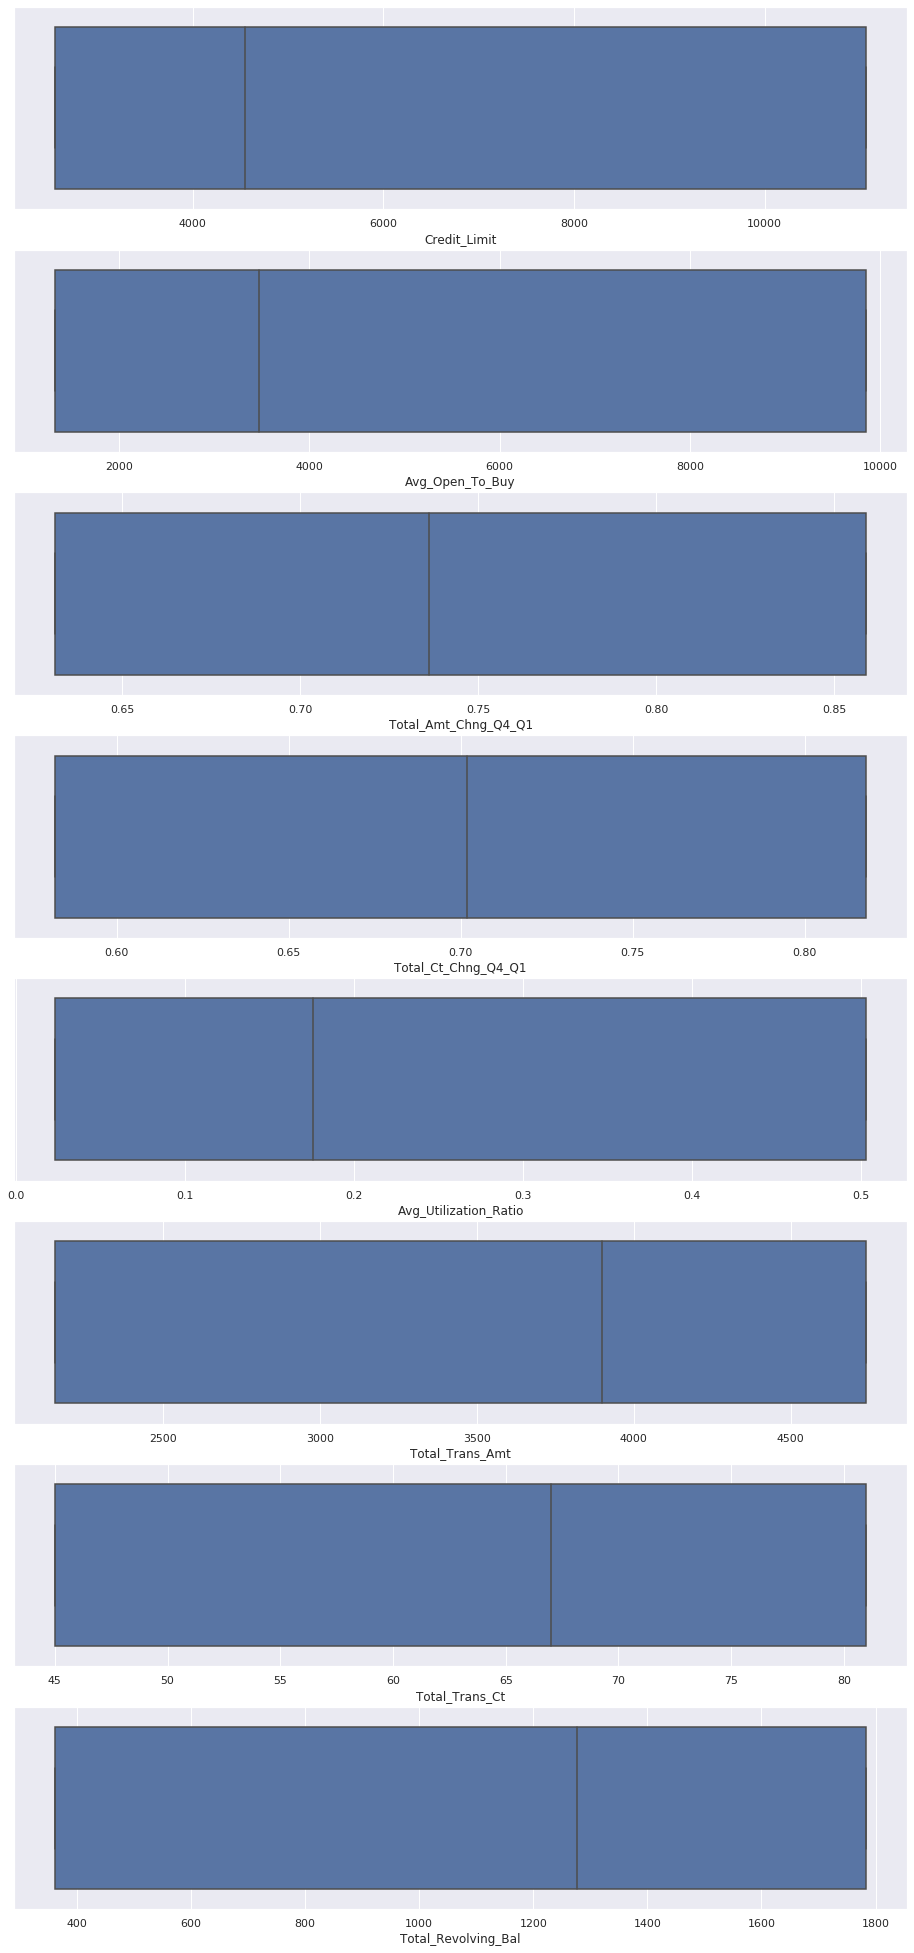

In [17]:
#checking to see if all outliers has being taken care of
sns.set(style= 'whitegrid')
sns.set(rc={'figure.figsize':(16,35)})
f, axes = plt.subplots(8, 1)
sns.boxplot(data['Credit_Limit'], ax = axes[0])
sns.boxplot(data['Avg_Open_To_Buy'], ax = axes[1])
sns.boxplot(data['Total_Amt_Chng_Q4_Q1'], ax = axes[2])
sns.boxplot(data['Total_Ct_Chng_Q4_Q1'], ax = axes[3])
sns.boxplot(data['Avg_Utilization_Ratio'], ax = axes[4])
sns.boxplot(data['Total_Trans_Amt'], ax = axes[5])
sns.boxplot(data['Total_Trans_Ct'], ax = axes[6])
sns.boxplot(data['Total_Revolving_Bal'], ax = axes[7])

In [15]:
#checking our dataset shape
data.shape

(10127, 20)

In [16]:
#performing label encoding on some categorical features and convert them to numerical values
from sklearn.preprocessing import LabelEncoder
#instantiating an object instance
le = LabelEncoder()
#fit and transform the feature variables concerned
data['Attrition_Flag'] = le.fit_transform(data['Attrition_Flag'])
data['Gender'] = le.fit_transform(data['Gender'])
data['Education_Level'] = le.fit_transform(data['Education_Level'])
data['Marital_Status'] = le.fit_transform(data['Marital_Status'])
data['Income_Category'] = le.fit_transform(data['Income_Category'])
data['Card_Category'] = le.fit_transform(data['Card_Category'])
data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,,,,,,,,,,,,,,,,,,,,
768805383,1,45,1,3,3,1,2,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
818770008,1,49,0,5,2,2,4,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
713982108,1,51,1,3,2,1,3,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
769911858,1,40,0,4,3,3,4,0,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
709106358,1,40,1,3,5,1,2,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [ ]:
#value count for the attrition flag
data['Attrition_Flag'].value_counts()

In [17]:
#extracting target variable and feature variables
target = data['Attrition_Flag']
feature = data.drop(['Attrition_Flag'], axis = 1)
print('Target shape:{}, Feature shape:{}'.format(target.shape, feature.shape))

Target shape:(10127,), Feature shape:(10127, 19)


DATA MODELLING PHASE

In [19]:
#splitting dataset into test and train dataset
#importing package - train-test split from library model selection
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size = 0.3, random_state = 20)

In [20]:
#verifying newly formed data shapes
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7088, 19), (3039, 19), (7088,), (3039,))

In [22]:
#importing all necessary packages for our model
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

#building our pipeline model
# we will make use of one transformer(svm) and one classifier(rfc) in our pipeline
#creating our estimator
estimator = [('dim_red', PCA(n_components=10)), ('rfc_model', RandomForestClassifier(n_estimators=600))]
#placing our estimator in a pipeline object
pipeline_estimator = Pipeline(estimator)
#fit the train data to the pipeline estimator
pipeline_estimator.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=10,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('rfc_model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=600, n_jobs=None,
                                        oob_score=False, random_state=None,
         

In [23]:
#Evaluating and checking our model accuracy
#checking model accuracy
pipeline_estimator.score(x_test, y_test)

0.9378084896347483

In [24]:
#Recall 1- existing customers, whereas 0- attrited customer
#creating predictions
predictions = pipeline_estimator.predict(x_test)
#import classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       459
           1       0.95      0.97      0.96      2580

    accuracy                           0.94      3039
   macro avg       0.89      0.86      0.87      3039
weighted avg       0.94      0.94      0.94      3039



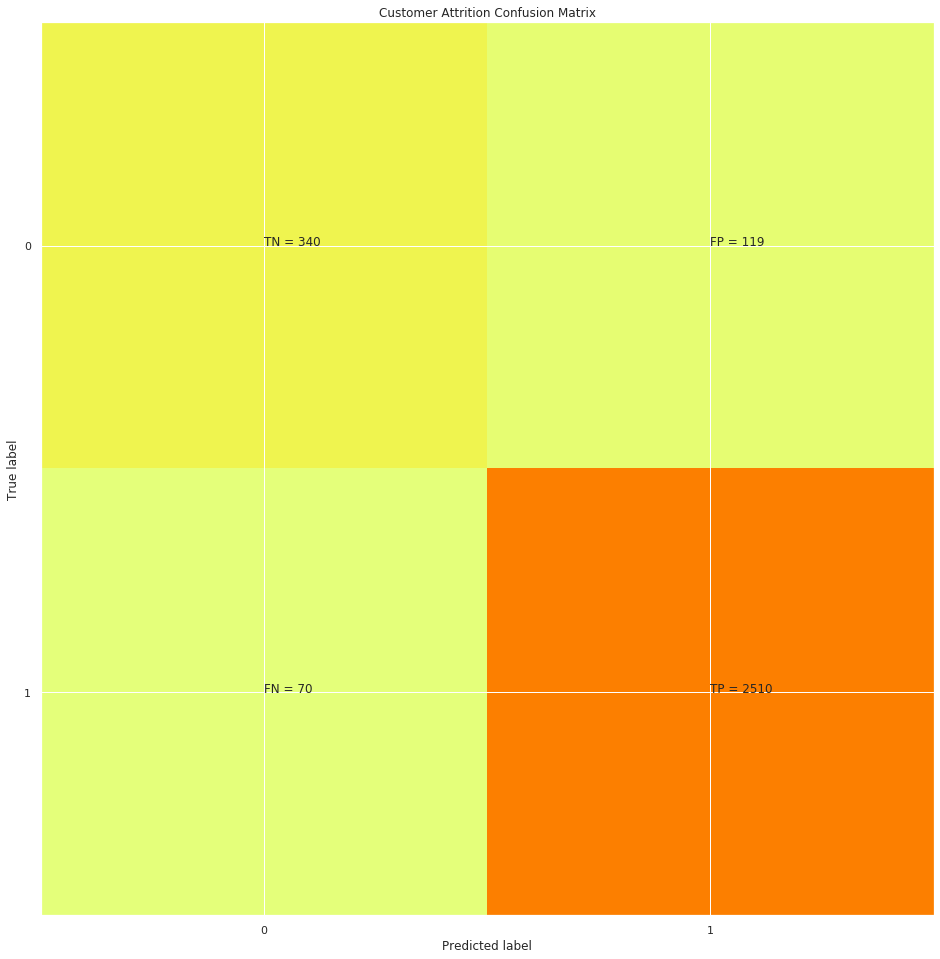

In [26]:
#displaying the confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = [0,1]
plt.title('Customer Attrition Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [27]:
#deploying our model
attrition_predictor = pipeline_estimator.deploy(initial_instance_count=1,instance_type='ml.t3.medium')

AttributeError: 'Pipeline' object has no attribute 'deploy'

In [25]:
#monitoring model performance